In [297]:
import glob

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

# turn off SettingWithCopyWarning
pd.options.mode.chained_assignment = None
pd.__version__, np.__version__

('2.3.3', '1.26.4')

This notebook contains the analysis of pose data.

1. First the shelter position is manually determined. Then head direction vectors, homing vectors and their absoloute angular difference (AAD) are calculated at each timepoint.

2. The angular velocity is then calculated as the first derivative of the AAD, and converted to absoloute values as well.
The absoloute angular vecocity is then plotted for all trials (for one mouse), and valid trials are manually selected for inclusion in the following steps.

3. The average AAD is calculated across all valid trials and plotted, together with the AAD from individual valid trials.



In [298]:
mouse_id = 6

In [299]:
df = pd.read_csv(f'../data/A{mouse_id}/trials.csv', header=[0, 1], index_col=[0, 1]) 

### find shelter position and table position

In [300]:
# list all video files
video_files = glob.glob(f'../data/A{mouse_id}/*.mp4')
video_files

# load first video
cap = cv2.VideoCapture(video_files[0])

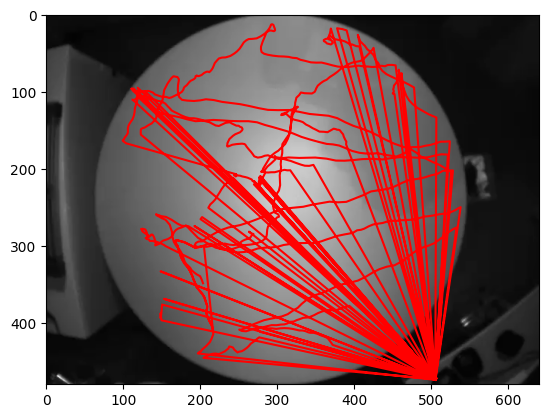

In [301]:
# show first frame as image
ret, frame = cap.read()

# plot trajectory of mouse on top of frame to check if coordinate systems match
plt.plot(df[('nose', 'x')], df[('nose', 'y')], color='red')
plt.imshow(frame)
plt.show()

# yes they match

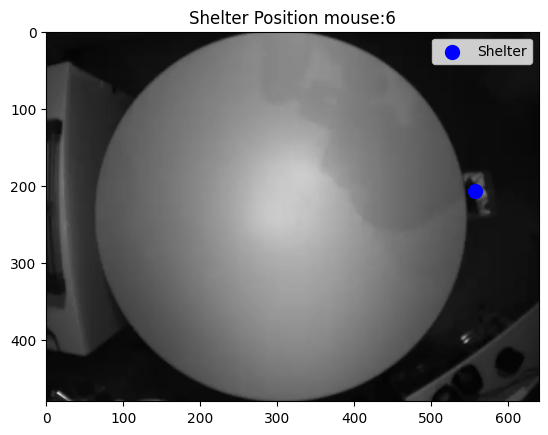

In [302]:
# determine shelter position

# define a point and visualize it
shelter_pos = (557, 206)  # example coordinates, replace with actual clicked coordinates
plt.imshow(frame)
plt.scatter(*shelter_pos, color='blue', s=100, label='Shelter')
plt.legend()
plt.title('Shelter Position mouse:{mouse_id}'.format(mouse_id=mouse_id))
plt.show()

In [303]:
# write shelter pos for each mouse into a dataframe manually
shelter_positions = {
    1: (930, 320),
    2: (999, 999),
    3: (920, 330),
    4: (577, 190),
    5: (590, 187),
    6: (557, 206),
}

shelter_df = pd.DataFrame.from_dict(shelter_positions, orient='index', columns=['shelter_x', 'shelter_y'])
shelter_df.index.name = 'mouse_id'
shelter_df

,shelter_x,shelter_y
mouse_id,,
1,930,320
2,999,999
3,920,330
4,577,190
5,590,187
6,557,206


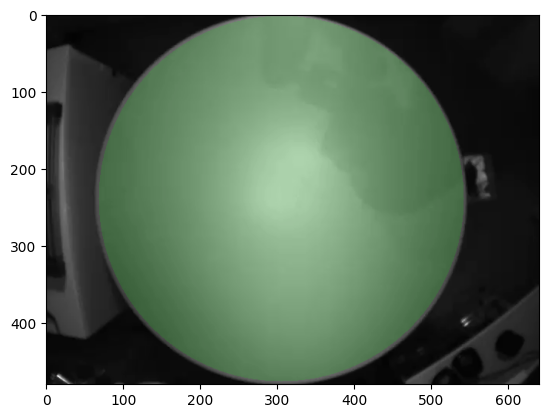

In [304]:
# determine middle and radius of of table

table_center = (305, 239)
table_radius = 237

# draw transpartent circle on frame to check
overlay = frame.copy()
cv2.circle(overlay, table_center, table_radius, (0, 255, 0), -1)
plt.imshow(frame)

# show transparent circle
alpha = 0.15  # transparency factor
plt.imshow(overlay, alpha=alpha)
plt.show()

In [305]:
# write table center and radius for each mouseinto dataframe
table_centers = {
    1: (537, 385),
    2: (999, 999),
    3: (516, 383),
    4: (330, 241),
    5: (345, 242),
    6: (305, 239),
}

table_radii = {
    1: 378,
    2: 999,
    3: 378,
    4: 237,
    5: 238,
    6: 237,
}
table_df = pd.DataFrame.from_dict(table_centers, orient='index', columns=['table_center_x', 'table_center_y'])
table_df.index.name = 'mouse_id'
table_df['table_radius'] = pd.Series(table_radii)
table_df


,table_center_x,table_center_y,table_radius
mouse_id,,,
1,537,385,378
2,999,999,999
3,516,383,378
4,330,241,237
5,345,242,238
6,305,239,237


### preprocessing

In [306]:
# let frame number start at 0 for each trial
df = df.reset_index()
df["frame_no"] = df.groupby('trial_number')['frame'].apply(lambda x: x - x.min()).values
df = df.set_index(['trial_number', 'frame_no'])

In [307]:
# if likelyhood is below .3, set to NaN
threshold = 0.33

for part in ['nose', 'left_ear', 'right_ear']:
    df.loc[df[(part, 'likelihood')] < threshold, (part, 'x')] = np.nan
    df.loc[df[(part, 'likelihood')] < threshold, (part, 'y')] = np.nan


# set whole rows to NaN if any part is NaN
df = df.dropna(subset=[('nose', 'x'), ('left_ear', 'x'), ('right_ear', 'x'),
                       ('nose', 'y'), ('left_ear', 'y'), ('right_ear', 'y')], how='any')

### head direction

In [308]:
# middle point between ears
df[('head', 'x')] = (df[('left_ear', 'x')] + df[('right_ear', 'x')]) / 2
df[('head', 'y')] = (df[('left_ear', 'y')] + df[('right_ear', 'y')]) / 2

# head direction vector
df[('head_dir', 'x')] = df[('nose', 'x')] - df[('head', 'x')]
df[('head_dir', 'y')] = df[('nose', 'y')] - df[('head', 'y')]

### homing vector 

In [309]:
# calculate homing vector
shelter_x, shelter_y = shelter_positions[mouse_id]
# homing vector
df[('homing_vector', 'x')] = shelter_x - df[('head', 'x')]
df[('homing_vector', 'y')] = shelter_y - df[('head', 'y')]
df

bodyparts             frame       nose                         left_ear  \
coords                               x          y likelihood          x   
trial_number frame_no                                                     
0            0          501  203.27860  348.31708   0.907227  203.30386   
             1          502  201.36856  343.04532   0.838379  200.85994   
             2          503  199.40384  339.09326   0.886230  197.62718   
             3          504  195.13237  336.79114   0.845703  195.08832   
             4          505  191.63360  334.18167   0.855469  191.65677   
...                     ...        ...        ...        ...        ...   
13           34         233  182.57024  111.06180   0.930176  169.47514   
             49         248  355.10126  129.69120   0.919922  343.63550   
             54         253  409.70764  147.52774   0.946289  400.56040   
             55         254  420.72840  151.72626   0.892578  411.89252   
             61         260  480.39975  178.72089   0.922852  475.04358   

bodyparts                                    right_ear                         \
coords                         y likelihood          x           y likelihood   
trial_number frame_no                                                           
0            0         359.14722   0.635742  209.96613  355.408630   0.859375   
             1         353.92450   0.679688  208.55817  350.567320   0.865234   
             2         349.74380   0.680176  205.92543  346.515840   0.839355   
             3         347.48026   0.691406  202.54729  343.002800   0.813477   
             4         344.21225   0.629395  198.93848  340.306900   0.804199   
...                          ...        ...        ...         ...        ...   
13           34        105.66083   0.351318  169.01254  113.827286   0.841309   
             49        123.55405   0.415771  343.05087  131.940000   0.827637   
             54        140.73230   0.447266  398.47275  148.502840   0.652344   
             55        144.36363   0.543945  409.69937  151.426900   0.786133   
             61        172.70032   0.345215  471.60712  179.742250   0.801758   

bodyparts                    head               head_dir            \
coords                          x           y          x         y   
trial_number frame_no                                                
0            0         206.634995  357.277925  -3.356395 -8.960845   
             1         204.709055  352.245910  -3.340495 -9.200590   
             2         201.776305  348.129820  -2.372465 -9.036560   
             3         198.817805  345.241530  -3.685435 -8.450390   
             4         195.297625  342.259575  -3.664025 -8.077905   
...                           ...         ...        ...       ...   
13           34        169.243840  109.744058  13.326400  1.317742   
             49        343.343185  127.747025  11.758075  1.944175   
             54        399.516575  144.617570  10.191065  2.910170   
             55        410.795945  147.895265   9.932455  3.830995   
             61        473.325350  176.221285   7.074400  2.499605   

bodyparts             homing_vector              
coords                            x           y  
trial_number frame_no                            
0            0           350.365005 -151.277925  
             1           352.290945 -146.245910  
             2           355.223695 -142.129820  
             3           358.182195 -139.241530  
             4           361.702375 -136.259575  
...                             ...         ...  
13           34          387.756160   96.255942  
             49          213.656815   78.252975  
             54          157.483425   61.382430  
             55          146.204055   58.104735  
             61           83.674650   29.778715  

[829 rows x 16 columns]

### absoloute angular difference (AAD)
between head direction vector and homing vector

In [310]:
# angle between head direction and shelter direction
def calculate_angle(row):
    # head direction vector
    head_dir = np.array([row[('head_dir', 'x')], row[('head_dir', 'y')]])
    
    # homing vector
    shelter_dir = np.array([row[('homing_vector', 'x')], row[('homing_vector', 'y')]])
    
    # calculate angle in degrees
    cos_theta = np.dot(head_dir, shelter_dir) / (np.linalg.norm(head_dir) * np.linalg.norm(shelter_dir))
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # clip to avoid numerical issues
    return np.degrees(angle)

In [311]:
df[('absoloute_angular_diff', 'degrees')] = df.apply(calculate_angle, axis=1)

In [312]:
# convert angle to absolute value between 0 and 180
df[('absoloute_angular_diff', 'degrees')] = df[('absoloute_angular_diff', 'degrees')].abs()
df["absoloute_angular_diff"]

coords                   degrees
trial_number frame_no           
0            0         87.180705
             1         87.409927
             2         82.903468
             3         92.319926
             4         93.756117
...                          ...
13           34         8.294038
             49        10.726734
             54         5.357109
             55         0.582107
             61         0.130085

[829 rows x 1 columns]

### absoloute angular velocity

In [313]:
# angular velocity from absoloute angular difference
df[("absoloute_angular_diff", "angular_velocity")] = df[('absoloute_angular_diff', 'degrees')].groupby(level='trial_number').diff().abs()
df["absoloute_angular_diff"]

# note: first value per trial will be NaN because of diff()

coords                   degrees  angular_velocity
trial_number frame_no                             
0            0         87.180705               NaN
             1         87.409927          0.229222
             2         82.903468          4.506459
             3         92.319926          9.416458
             4         93.756117          1.436191
...                          ...               ...
13           34         8.294038          4.074774
             49        10.726734          2.432696
             54         5.357109          5.369625
             55         0.582107          4.775002
             61         0.130085          0.452022

[829 rows x 2 columns]

### inspect angular velocity per trial

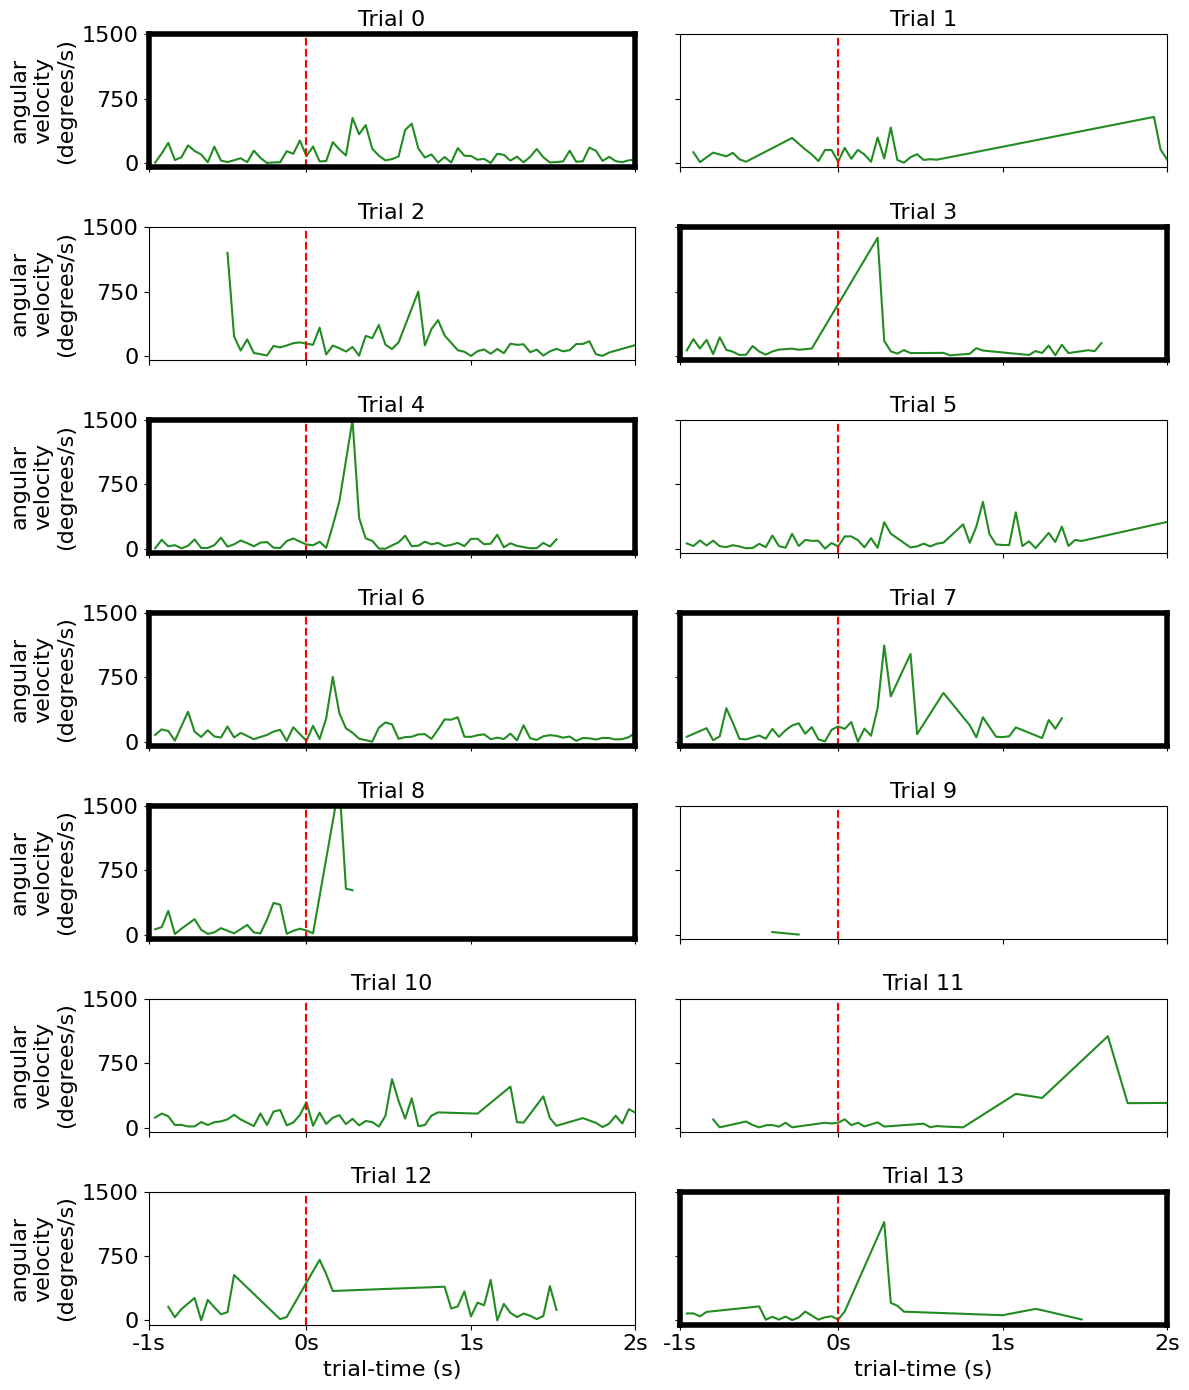

In [314]:
# plots trials underneath each other
# separate plot for each trial
trial_numbers = df.index.get_level_values('trial_number').unique()
num_trials = len(trial_numbers)

fronsize_axislabels = 16

# valid trials for different mice
valid_trials_dict = {
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [0, 3, 4, 6, 7, 8, 13]
}
selected_trials = valid_trials_dict[mouse_id]

plt.subplots(7,2, figsize=(12, 1. * num_trials), sharex=True, sharey=True)
#fig.suptitle('Angular Velocity per Trial - Mouse {mouse_id}'.format(mouse_id=mouse_id), size=30)
for i, trial_number in enumerate(trial_numbers):
    trial_data = df.xs(trial_number, level='trial_number')
    plt.subplot(7, 2,i+1)
    plt.plot(trial_data.index.get_level_values('frame_no'), trial_data[('absoloute_angular_diff', 'angular_velocity')]*25, color="forestgreen")
    plt.xlim(0, 74)
    plt.ylim(-50, 60*25)
    plt.title('Trial {trial_number}'.format(trial_number=trial_number), size=fronsize_axislabels)
    plt.axvline(x=24, color='red', linestyle='--')
    plt.tick_params(axis='y', labelsize=fronsize_axislabels)
    if i % 2 == 0:
        plt.ylabel('angular\nvelocity\n(degrees/s)', size=fronsize_axislabels)
        plt.yticks([0, 750, 1500], ["0", "750", "1500"], size=fronsize_axislabels)
    if i == num_trials - 1 or i == num_trials - 2:
        plt.xlabel('trial-time (s)', size = fronsize_axislabels)
        plt.xticks([0, 24, 49, 74], ["-1s", "0s", "1s", "2s"], size=fronsize_axislabels)
    
    # draw box around selected trials
    if trial_number in selected_trials:
        for spine in plt.gca().spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(4)

    # adjust spacing between subplots
plt.tight_layout(h_pad=2.0)
plt.show()

### select valid trials and plot

trials are selected in the code box before to include information in previous plot already

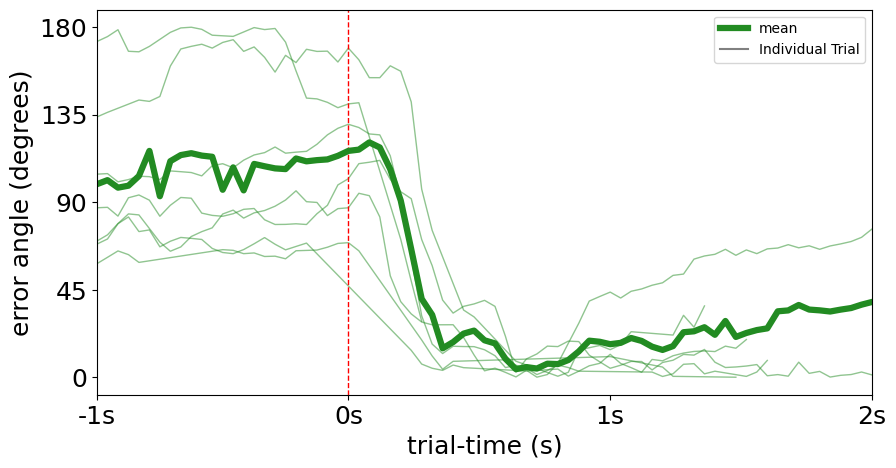

In [315]:
plt.figure(figsize=(10, 5))
# plot homing vector angle for selected trials
for trial_number in selected_trials:
    trial_data = df.xs(trial_number, level='trial_number')
    plt.plot(trial_data.index.get_level_values('frame_no'), trial_data[('absoloute_angular_diff', 'degrees')], color="forestgreen", alpha=0.5, linewidth=1)
# plot mean across selected trials, select trials from df to do so df.xs(selected_trials, level='trial_number') doesnt work 
selected_data = df.loc[selected_trials]
mean_selected = selected_data[('absoloute_angular_diff', 'degrees')].groupby(level='frame_no').mean()


fronsize_axislabels = 18
# indicate start of trial with vertical line
plt.axvline(x=24, color='red', linestyle='--', linewidth=1)
plt.plot(mean_selected.index.get_level_values('frame_no'), mean_selected.values, label='mean', color='forestgreen', linewidth=4.5)
plt.xlabel('trial-time (s)', size=fronsize_axislabels)
plt.ylabel('error angle (degrees)', size=fronsize_axislabels)
#plt.title('Homing Vector ERROR Angle for Selected Trials - Mouse {mouse_id}'.format(mouse_id=mouse_id), size=20)
plt.xlim(0, 74)
plt.xticks([0, 24, 49, 74], labels=["-1s", "0s", "1s", "2s"], size=fronsize_axislabels);
plt.yticks([0, 45, 90, 135, 180], size=fronsize_axislabels);

# custimize legend, plot one grey line with label "Individual Trials"
plt.plot([], [], color='grey', label='Individual Trial')
plt.legend()
plt.show()

In [316]:
# calculate min error angle for each trial
min_error_angles = {}
for trial_number in selected_trials:
    trial_data = df.xs(trial_number, level='trial_number')
    min_error_angle = trial_data[('absoloute_angular_diff', 'degrees')].min()
    min_error_angles[trial_number] = min_error_angle

In [317]:
min_error_angles

{0: 0.21331489280218913,
 3: 0.5226542763127189,
 4: 1.5076203115347167,
 6: 0.16593785089016352,
 7: 0.6406345228396627,
 8: 28.85165573903862,
 13: 0.13008514521436773}